In [1]:
import os
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

# from jax import config
# config.update("jax_enable_x64", True)

import jax.numpy as jnp
import numpy as np
import plotly.io as pio
pio.renderers.default = "browser"

import matplotlib.pyplot as plt
import plotly.graph_objects as go

import cbvf_reachability as cbvf

from dyn_sys.MzNonlinearCar import MzNonlinearCar
from controllers.CBVF_QP import CBVFQPController
from controllers.CBVFInterpolator import CBVFInterpolator


In [2]:
dynamics = MzNonlinearCar()

# limits of the grid in degrees
x1_lim = 250
x2_lim = 90

x1_lim = x1_lim * jnp.pi / 180
x2_lim = x2_lim * jnp.pi / 180

grid = cbvf.Grid.from_lattice_parameters_and_boundary_conditions(cbvf.sets.Box(np.array([-x1_lim, -x2_lim]),
                                                                           np.array([x1_lim, x2_lim])),
                                                                           (500, 500))
values_vi = jnp.linalg.norm(grid.states[..., :2], axis=-1) - 5 * jnp.pi / 180  # radius in radians
values = jnp.linalg.norm(grid.states[..., :2], axis=-1) - 5 * jnp.pi / 180  # radius in radians
initial_values = values_vi.copy()

solver_settings = cbvf.SolverSettings.with_accuracy(
    "very_high",
    hamiltonian_postprocessor=cbvf.solver.identity,
)



times = np.linspace(0, -0.5, 400)

In [3]:
# time = 0.
# target_time = -0.3
# solver_settings = cbvf.SolverSettings.with_accuracy("cbvf",
#                                                   hamiltonian_postprocessor=cbvf.solver.identity,
#                                                   gamma=5)
# target_values_vi = cbvf.step_cbvf(solver_settings, dynamics, grid, time, values_vi, target_time, initial_values)
# solver_settings = cbvf.SolverSettings.with_accuracy("very_high",
#                                                   hamiltonian_postprocessor=cbvf.solver.backwards_reachable_tube)
# target_values = cbvf.step(solver_settings, dynamics, grid, time, values, target_time)

In [4]:
solver_settings = cbvf.SolverSettings.with_accuracy("cbvf",
                                                  hamiltonian_postprocessor=cbvf.solver.identity,
                                                  gamma=0.1)
target_values_vi = cbvf.solve_cbvf(solver_settings, dynamics, grid, times, values, initial_values)
# solver_settings = cbvf.SolverSettings.with_accuracy(
#     "very_high",
#     hamiltonian_postprocessor=cbvf.solver.backwards_reachable_tube,
# )
# target_values = cbvf.solve(solver_settings, dynamics, grid, times, initial_values)

100%|##########|  0.5000/0.5 [00:11<00:00, 22.37s/sim_s]


In [5]:
safe_controller = CBVFQPController(value_fn=CBVFInterpolator(grid, -target_values_vi, times, gamma=0.0), gamma=0.0, verbose=True)

In [8]:
# Simulation parameters
initial_state = jnp.array([-100 * (jnp.pi/180), -40 * (jnp.pi/180)])  # Initial state [yaw_rate, sideslip] in radians
sim_time = 0.5  # Total simulation time in seconds
dt = 0.001  # Time step for integration
u_ref_value = -15000  # Reference control (constant positive yaw moment)

# Initialize storage for trajectory
time_sim = np.arange(0, sim_time, dt)
trajectory = np.zeros((len(time_sim), 2))
controls = np.zeros(len(time_sim))
cbvf_values = np.zeros(len(time_sim))

# Set initial state
current_state = initial_state
trajectory[0] = current_state

# Simulation loop
for i, t in enumerate(time_sim[:-1]):
    # Compute reference control (constant max positive input)
    u_ref = jnp.array([u_ref_value])

    # Compute safe control using CBVF-QP
    u_safe = safe_controller.compute_safe_control(
        state=current_state,
        time=t,
        u_ref=u_ref,
        dynamics=dynamics
    )

    # Store control
    controls[i] = u_safe[0]

    # Get CBVF value at current state
    cbvf_val, _, _ = safe_controller.cbvf.get_value_and_gradients(current_state, t)
    cbvf_values[i] = cbvf_val

    # Integrate dynamics forward (simple Euler integration)
    state_dot = dynamics(current_state, u_safe, jnp.array([0.0]), t)
    current_state = current_state + dt * state_dot

    # Store next state
    if i < len(time_sim) - 1:
        trajectory[i + 1] = current_state

# Convert trajectory to degrees for visualization
trajectory_deg = trajectory * 180 / jnp.pi


print(f"Simulation completed. Final state: yaw_rate={trajectory_deg[-1, 0]:.2f} deg/s, sideslip={trajectory_deg[-1, 1]:.2f} deg")
print(f"Max CBVF value during trajectory: {np.max(cbvf_values):.4f}")

CBVF profile for state [-1.7453293 -0.6981317]:
  Safe threshold: 0.0
  Max value: 0.08578149974346161 at time -0.48621553884711777
  Entry time: -0.4223057644110275
Current state: [-1.7453293 -0.6981317], time: 0.0, reference control: [-15000]
Gradient time for safe entry: -0.4223057644110275
CBVF profile for state [-1.7428255 -0.6948192]:
  Safe threshold: 0.0
  Max value: 0.08579040318727493 at time -0.4849624060150376
  Entry time: -0.42105263157894735
Current state: [-1.7428255 -0.6948192], time: 0.001, reference control: [-15000]
Gradient time for safe entry: -0.42105263157894735
CBVF profile for state [-1.7409774  -0.69150925]:
  Safe threshold: 0.0
  Max value: 0.08579845726490021 at time -0.48370927318295737
  Entry time: -0.4197994987468672
Current state: [-1.7409774  -0.69150925], time: 0.002, reference control: [-15000]
Gradient time for safe entry: -0.4197994987468672
CBVF profile for state [-1.73879   -0.6882011]:
  Safe threshold: 0.0
  Max value: 0.08580685406923294 at 

KeyboardInterrupt: 

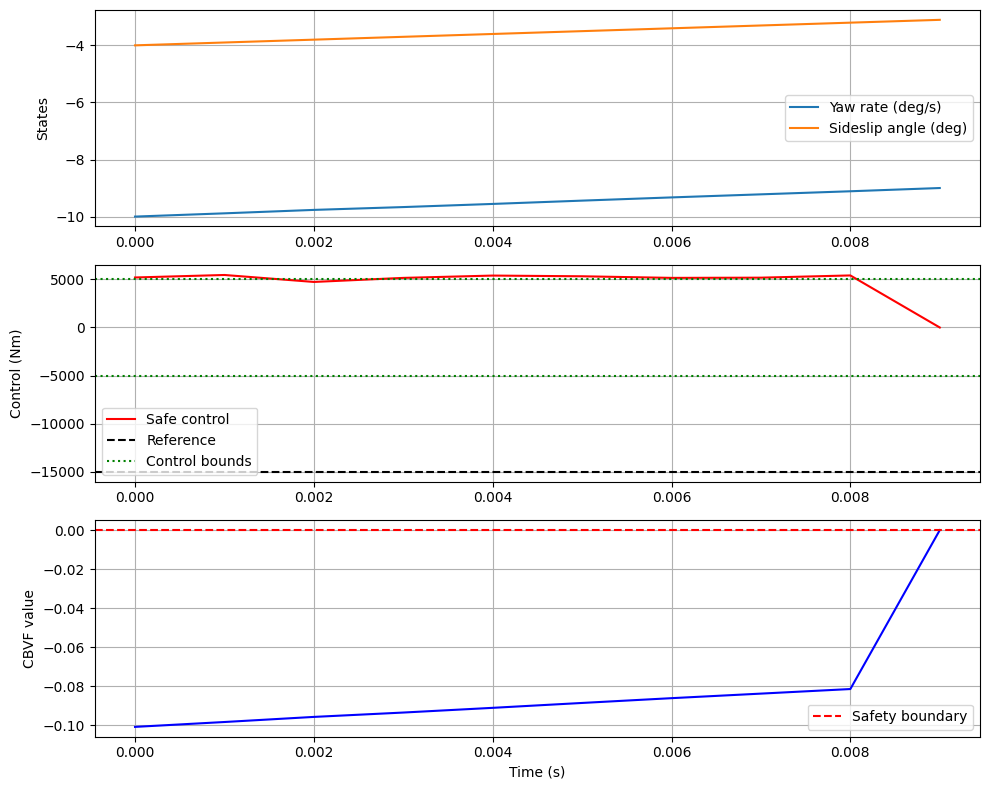

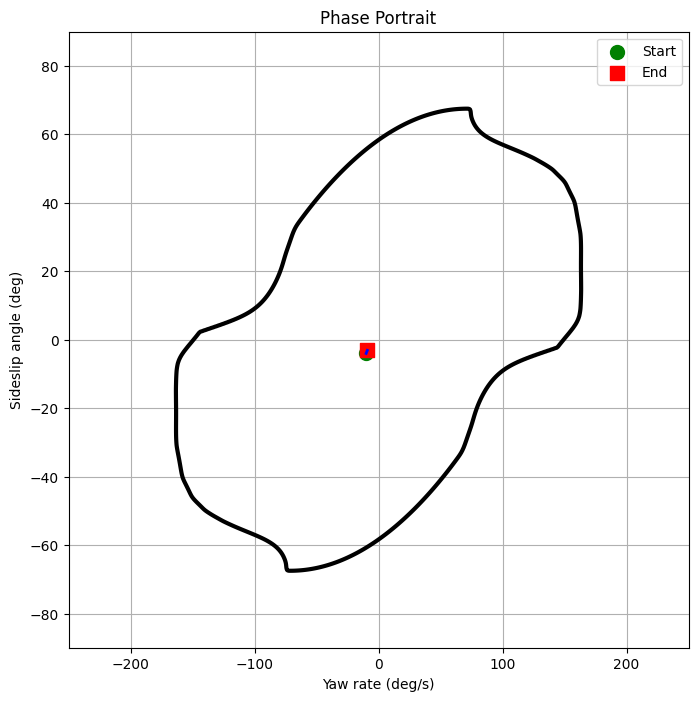

In [7]:
# Plot results
fig, axes = plt.subplots(3, 1, figsize=(10, 8))

# State trajectory
axes[0].plot(time_sim, trajectory_deg[:, 0], label='Yaw rate (deg/s)')
axes[0].plot(time_sim, trajectory_deg[:, 1], label='Sideslip angle (deg)')
axes[0].set_ylabel('States')
axes[0].legend()
axes[0].grid(True)

# Control input
axes[1].plot(time_sim, controls, 'r-', label='Safe control')
axes[1].axhline(y=u_ref_value, color='k', linestyle='--', label='Reference')
axes[1].axhline(y=dynamics.car_params['Mz'], color='g', linestyle=':', label='Control bounds')
axes[1].axhline(y=-dynamics.car_params['Mz'], color='g', linestyle=':')
axes[1].set_ylabel('Control (Nm)')
axes[1].legend()
axes[1].grid(True)

# CBVF value
axes[2].plot(time_sim, cbvf_values, 'b-')
axes[2].axhline(y=0, color='r', linestyle='--', label='Safety boundary')
axes[2].set_xlabel('Time (s)')
axes[2].set_ylabel('CBVF value')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()

# Phase portrait
plt.figure(figsize=(8, 8))
plt.plot(trajectory_deg[:, 0], trajectory_deg[:, 1], 'b-', linewidth=2)
plt.scatter(trajectory_deg[0, 0], trajectory_deg[0, 1], color='g', s=100, marker='o', label='Start')
plt.scatter(trajectory_deg[-1, 0], trajectory_deg[-1, 1], color='r', s=100, marker='s', label='End')

# Add zero-level set contour if you want to visualize the safe boundary
# You would need to evaluate this at the appropriate time slice
plt.xlabel('Yaw rate (deg/s)')
plt.ylabel('Sideslip angle (deg)')
plt.title('Phase Portrait')
plt.legend()
plt.grid(True)
# plt.axis('equal')
plt.xlim(-x1_lim * 180 / jnp.pi, x1_lim * 180 / jnp.pi)
plt.ylim(-x2_lim * 180 / jnp.pi, x2_lim * 180 / jnp.pi)
plt.contour(grid.coordinate_vectors[0] * 180 / jnp.pi,
            grid.coordinate_vectors[1] * 180 / jnp.pi,
            target_values_vi[399, :, :].T,
            levels=0,
            colors="black",
            linewidths=3)
plt.show()

In [ ]:
plot_time_index = len(times) // 2

In [ ]:
plt.jet()
plt.figure(figsize=(13, 8))
plt.contourf(grid.coordinate_vectors[0], grid.coordinate_vectors[1], target_values[:, :].T)
plt.colorbar()
plt.contour(grid.coordinate_vectors[0],
            grid.coordinate_vectors[1],
            target_values[:, :].T,
            levels=0,
            colors="black",
            linewidths=3)

In [ ]:
plt.jet()
plt.figure(figsize=(13, 8))
plt.contourf(grid.coordinate_vectors[0] * 180 / jnp.pi, grid.coordinate_vectors[1] * 180 / jnp.pi, target_values_vi[399, :, :].T)
plt.colorbar()
plt.contour(grid.coordinate_vectors[0] * 180 / jnp.pi,
            grid.coordinate_vectors[1] * 180 / jnp.pi,
            target_values_vi[399, :, :].T,
            levels=0,
            colors="black",
            linewidths=3)

In [ ]:
f = go.Figure(data=go.Surface(z=target_values[:, :].T,
                                         x=grid.coordinate_vectors[0],
                                         y=grid.coordinate_vectors[1],
                                         colorscale="Jet",
                                         contours={
                                             "z": {
                                                 "show": True,
                                                 "start": 0.00,
                                                 "end": 0.00,
                                                 "size": 1
                                             }
                                         }))
f.update_layout(title="Reachable Set for MzNonlinearCar (norm)",
                  scene=dict(xaxis_title="x1",
                             yaxis_title="x2",
                             zaxis_title="value"),
                  width=800,
                  height=800,
                  xaxis=dict(range=[-x1_lim, x1_lim]),
                  yaxis=dict(range=[-x2_lim, x2_lim]),
                  scene_aspectmode='cube')
f.show()

In [ ]:
f = go.Figure(data=go.Surface(z=-target_values_vi[-1, :, :].T,
                                         x=grid.coordinate_vectors[0],
                                         y=grid.coordinate_vectors[1],
                                         colorscale="Jet",
                                         contours={
                                             "z": {
                                                 "show": True,
                                                 "start": 0.00,
                                                 "end": 0.00,
                                                 "size": 1
                                             }
                                         }))
f.update_layout(title="Reachable Set for MzNonlinearCar (Alt)",
                  scene=dict(xaxis_title="x1",
                             yaxis_title="x2",
                             zaxis_title="value"),
                  width=800,
                  height=800,
                  xaxis=dict(range=[-x1_lim, x1_lim]),
                  yaxis=dict(range=[-x2_lim, x2_lim]),
                  scene_aspectmode='cube')
f.show()

In [ ]:
f = go.Figure(data=go.Surface(z=target_values_vi[:, :].T - target_values[:, :].T,
                                         x=grid.coordinate_vectors[0],
                                         y=grid.coordinate_vectors[1],
                                         colorscale="Jet",
                                         contours={
                                             "z": {
                                                 "show": True,
                                                 "start": 0.00,
                                                 "end": 0.00,
                                                 "size": 1
                                             }
                                         }))
f.update_layout(title="Difference in sets",
                  scene=dict(xaxis_title="x1",
                             yaxis_title="x2",
                             zaxis_title="value"),
                  width=800,
                  height=800,
                  xaxis=dict(range=[-x1_lim, x1_lim]),
                  yaxis=dict(range=[-x2_lim, x2_lim]),
                  scene_aspectmode='cube')
f.show()